# Exploring nascent quantification

A reviewer perceptively asked how much the inaccurate quantification of nascent counts affects inferred parameters.


Here, we simulate the inaccuracy of quantification by taking a certain random percent of the nascent counts and adding them to the mature counts for the same gene. 

That is, if in the dataset there are 100 TOTAL counts for nascent molecules over all cells and genes, and we "mis-quantify" 5% of them, a nascent counts will be chosen at random from the nascent matrix, subtracted from that gene count, and added to the same gene in the mature matrix five times. 



In [1]:
# System
import time, gc

# add module paths to sys path
import sys
sys.path.insert(0, '../../BIVI/')

# Math
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold

# to save results
import pickle

# scvi
import anndata
import scvi



# import biVI scripts
import biVI


# reproducibility -- set random seeds
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
np.random.seed(8675309)
 

# first, clear out cuda
torch.cuda.empty_cache()
gc.collect()



Global seed set to 0
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


10

In [2]:
# # Load in data 
data_dir = '../data/allen/'
name = 'F08_processed_hv'
adata = anndata.read_loom(data_dir+f'{name}.loom')

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

# can change as necessary for data. 
adata.obs['Cluster'] = adata.obs['Cell Type']
adata.var_names_make_unique()


#Set up train/test data splits with 5-fold split
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
skf_splits = skf.split(adata, adata.obs['Cluster'])

# Use last of the K-fold splits
for k, (train_index, test_index) in enumerate(skf_splits):
  pass

print(f'training on {len(train_index)} cells, testing on {len(test_index)} cells')

training on 5492 cells, testing on 1373 cells


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/scikit_learn-1.0.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [3]:
adata.X[:2000].sum()

6980438.0

In [4]:
total_nascent_counts = adata.layers['counts'][:,:2000].sum()
N_cells = adata.shape[0]
N_genes = 2000

    ## Set model parameters
model_args = {
                  'n_latent'     : 10,
                  'n_layers'     : 3,
                  'dispersion'   : 'gene',
                  'n_hidden'     : 10,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal',
                  }
    

In [75]:
fraction = 0.10
adata_mq = adata.copy()
 
filt = adata_mq.layers['counts'][:,:2000]>0
row_indices, col_indices = filt.nonzero()

filt2 = np.random.random(size=row_indices.shape[0])<fraction
selected_y = col_indices[filt2]
selected_x = row_indices[filt2]

adata_mq.layers['counts'][selected_x,selected_y] -= 1
adata_mq.layers['counts'][selected_x,selected_y+2000] += 1

np.sum(adata_mq.layers['counts'] != adata.layers['counts'])

304236

# Fit *biVI*

In [76]:
fractions = [0.00001,0.01,0.05,0.1,0.3,0.5]
fractions = [0.00001]


for fraction in fractions:
    max_epochs = 400
    adata_mq = adata.copy()
 
    filt = adata_mq.layers['counts'][:,:2000]>0
    row_indices, col_indices = filt.nonzero()

    filt2 = np.random.random(size=row_indices.shape[0])<fraction
    selected_y = col_indices[filt2]
    selected_x = row_indices[filt2]

    adata_mq.layers['counts'][selected_x,selected_y] -= 1
    adata_mq.layers['counts'][selected_x,selected_y+2000] += 1
    
#     train_adata, test_adata = adata_mq[train_index], adata_mq[test_index]
#     train_adata = train_adata.copy()
#     test_adata = test_adata.copy()
    
    biVI.biVI.setup_anndata(adata_mq,layer="counts")
#     biVI.biVI.setup_anndata(train_adata,layer="counts")


    ## Create model
    model = biVI.biVI(adata_mq,mode='Bursty',**model_args)
    ## Train model
    plan_kwargs = {'lr' : 1e-3,
                   'n_epochs_kl_warmup' : max_epochs/2,
                   }
    
    start = time.time()
    model.train(max_epochs = max_epochs,
                #early_stopping_monitor = ["reconstruction_loss_validation"],
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

    
    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    
    # get parameters
    parameters = model.get_likelihood_parameters()
    parameters['selected_y'] = selected_y 
    parameters['selected_x'] = selected_x
    
    ## Save training history
    parameters['reconstruction_error_train_set'] = [model.history['reconstruction_loss_train']]
    parameters['reconstruction_error_test_set'] = [model.history['reconstruction_loss_validation']]

    parameters['runtime'] = runtime
    parameters['memory_used'] = memory_used
    
    with open(f'../results/Bursty_{name}_{fraction}_nascent_results_dict','wb') as file:
        pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)
        
    del model
    torch.cuda.empty_cache()
    gc.collect()

{'n_input': 4000, 'n_hidden': 10, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|██████████| 400/400 [19:26<00:00,  2.90s/it, loss=1.55e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [19:26<00:00,  2.92s/it, loss=1.55e+03, v_num=1]
Bursty mode, getting parameters
Epoch 8/400:   2%|▏         | 7/400 [21:33<20:09:59, 184.73s/it, loss=1.99e+03, v_num=1]


-------

# Plotting results



In [5]:
# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# correlation
import scipy.stats

color_list = [sns.color_palette()[0], sns.color_palette("YlOrBr")[1],
              sns.color_palette("YlOrBr")[3],sns.color_palette("YlOrBr")[5]]

In [16]:
# load in data and add to dictionary
name = 'F08_processed_hv'
fractions = [1e-05,0.01,0.05,0.1]
compare_against = '1e-05'

b_dict = {}
beta_dict = {}
gamma_dict = {}

correlation_list = []
fraction_list = []
parameter_list = []
MSE_list = []
avg_correlation_list = []
avg_MSE_list = []

results_file = open(f'../results/{name}_results_dict.pickle', 'rb')
results_dict_ = pickle.load(results_file)
results_file.close()
b_dict['0'] = results_dict_['Bursty-10-NAS_SHAPE']['params']['burst_size'] 
beta_dict['0'] = results_dict_['Bursty-10-NAS_SHAPE']['params']['rel_splicing_rate'] 
gamma_dict['0'] = results_dict_['Bursty-10-NAS_SHAPE']['params']['rel_degradation_rate'] 

results_file = open(f'../results/Bursty_{name}_{compare_against}_nascent_results_dict', 'rb')
results_dict_ = pickle.load(results_file)
results_file.close()
b_dict[compare_against] = results_dict_['burst_size'] 
beta_dict[compare_against] = results_dict_['rel_splicing_rate'] 
gamma_dict[compare_against] = results_dict_['rel_degradation_rate'] 



for fraction in fractions:
    print(fraction)
    results_file = open(f'../results/Bursty_{name}_{fraction}_nascent_results_dict', 'rb')
    results_dict_ = pickle.load(results_file)
    results_file.close()
    N = len(results_dict_['selected_y'])
    print('Number of misquantified nascent counts: ',N)
    print('Number of misquantified nascent counts/ total nascent counts ', N/6980438)
    print('Percent misquantified nascent counts ', 100*N/6980438)
    
    b_dict[str(fraction)] = results_dict_['burst_size']
    fraction_list.append(str(fraction))
    parameter_list.append('burst_size')
    MSE_list.append(np.mean((b_dict[compare_against].flatten()-results_dict_['burst_size'].flatten())**2))
    correlation_list.append(scipy.stats.pearsonr(np.log(b_dict[compare_against].flatten()), 
                                                 np.log(results_dict_['burst_size'].flatten()))[0])
    avg_MSE_list.append(np.mean((b_dict[compare_against].flatten()-results_dict_['burst_size'].flatten())**2))
    avg_correlation_list.append(scipy.stats.pearsonr(np.log(np.mean(b_dict[compare_against],axis=0)), 
                                                 np.log(np.mean(results_dict_['burst_size'],axis=0)))[0])
    
    beta_dict[str(fraction)] = results_dict_['rel_splicing_rate']
    fraction_list.append(str(fraction))
    parameter_list.append('rel_splicing_rate')
    MSE_list.append(np.mean((beta_dict[compare_against].flatten()-results_dict_['rel_splicing_rate'].flatten())**2))
    correlation_list.append(scipy.stats.pearsonr(np.log(beta_dict[compare_against].flatten()), 
                                                 np.log(results_dict_['rel_splicing_rate'].flatten()))[0])
    avg_MSE_list.append(np.mean((beta_dict[compare_against].flatten()-results_dict_['rel_splicing_rate'].flatten())**2))
    avg_correlation_list.append(scipy.stats.pearsonr(np.log(np.mean(beta_dict[compare_against],axis=0)), 
                                                 np.log(np.mean(results_dict_['rel_splicing_rate'],axis=0)))[0])
    
    
    gamma_dict[str(fraction)] = results_dict_['rel_degradation_rate']
    fraction_list.append(str(fraction))
    parameter_list.append('rel_degradation_rate')
    MSE_list.append(np.mean((gamma_dict[compare_against].flatten()-results_dict_['rel_degradation_rate'].flatten())**2))
    correlation_list.append(scipy.stats.pearsonr(np.log(gamma_dict[compare_against].flatten()), 
                                                 np.log(results_dict_['rel_degradation_rate'].flatten()))[0])
    avg_MSE_list.append(np.mean((gamma_dict[compare_against].flatten()-results_dict_['rel_degradation_rate'].flatten())**2))
    avg_correlation_list.append(scipy.stats.pearsonr(np.log(np.mean(gamma_dict[compare_against],axis=0)), 
                                                 np.log(np.mean(results_dict_['rel_degradation_rate'],axis=0)))[0])
    
    



1e-05
Number of misquantified nascent counts:  22
Number of misquantified nascent counts/ total nascent counts  3.1516646949661324e-06
Percent misquantified nascent counts  0.00031516646949661327
0.01
Number of misquantified nascent counts:  15262
Number of misquantified nascent counts/ total nascent counts  0.002186395753389687
Percent misquantified nascent counts  0.2186395753389687
0.05
Number of misquantified nascent counts:  76696
Number of misquantified nascent counts/ total nascent counts  0.010987276156596478
Percent misquantified nascent counts  1.0987276156596477
0.1
Number of misquantified nascent counts:  152402
Number of misquantified nascent counts/ total nascent counts  0.02183272740191948
Percent misquantified nascent counts  2.183272740191948


In [17]:
colors = np.array(sns.diverging_palette(22, 220, as_cmap=False))[np.array([0,1,-2,-1],dtype=int)]

4


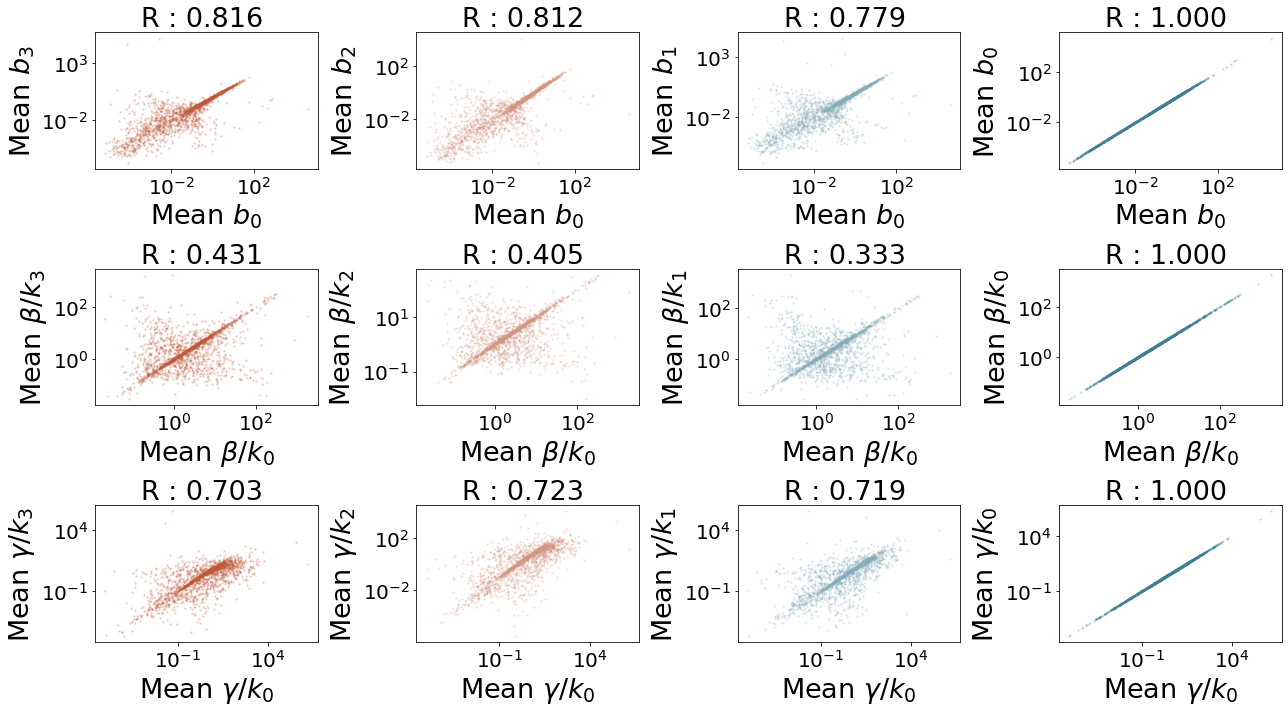

In [19]:
# and PLOT -- 3 by 15
fs = 27
print(len(fractions))
fig, ax = plt.subplots(3,len(fractions),figsize=(18,10))
# colors = sns.diverging_palette(22, 220, as_cmap=False)

nums = [3,2,1,0]
for i,fraction in enumerate(fractions[::-1]):
    
    # plot burst sizes against each other 
    ax[0,i].scatter(b_dict[compare_against].mean(axis=0),b_dict[str(fraction)].mean(axis=0),alpha=0.2,s=2,color=colors[i])
    ax[0,i].set_xlabel('Mean $b_0$',fontsize=fs)
    ax[0,i].set_ylabel(f'Mean $b_{nums[i]}$',fontsize=fs)
    avg_correlation_ = scipy.stats.pearsonr(np.log(np.mean(b_dict[compare_against],axis=0)), 
                                                 np.log(b_dict[str(fraction)].mean(axis=0)))[0]
    ax[0,i].set_title(f'R : {avg_correlation_:.3f} ',fontsize=fs)
    
    # plot splicing rates against each other 
    ax[1,i].scatter(beta_dict[compare_against].mean(axis=0),beta_dict[str(fraction)].mean(axis=0),
                    alpha=0.2,s=2,color=colors[i])
    ax[1,i].set_xlabel('Mean $\\beta / k _0$',fontsize=fs)
    ax[1,i].set_ylabel(f'Mean $\\beta / k _{nums[i]}$',fontsize=fs)
    avg_correlation_ = scipy.stats.pearsonr(np.log(np.mean(beta_dict[compare_against],axis=0)), 
                                                 np.log(beta_dict[str(fraction)].mean(axis=0)))[0]
    ax[1,i].set_title(f'R : {avg_correlation_:.3f} ',fontsize=fs)
    
    # plot degradation rates against each other
    ax[2,i].scatter(gamma_dict[compare_against].mean(axis=0),gamma_dict[str(fraction)].mean(axis=0),alpha=0.2,s=2,color=colors[i])
    ax[2,i].set_xlabel('Mean $\gamma / k _0$',fontsize=fs)
    ax[2,i].set_ylabel(f'Mean $\gamma / k _{nums[i]}$',fontsize=fs)
    avg_correlation_ = scipy.stats.pearsonr(np.log(np.mean(gamma_dict[compare_against],axis=0)), 
                                                 np.log(gamma_dict[str(fraction)].mean(axis=0)))[0]
    ax[2,i].set_title(f'R : {avg_correlation_:.3f} ',fontsize=fs)
    
    
    for j in range(3):
        ax[j,i].set_xscale('log')
        ax[j,i].set_yscale('log')
        
    
plt.tight_layout()
    
    

In [20]:
# plot mean squared error and correlations
df_plot = pd.DataFrame({
    'MSE' : MSE_list,
    'Correlation (R)' : correlation_list,
    'Fraction' : fraction_list,
    'Parameter' : parameter_list,
    'Percent' : np.array(fraction_list,dtype=np.float64)*100,
    'MSE (avg)' : avg_MSE_list,
    'Correlation (R) avg' : avg_correlation_list,
    'Accuracy' : np.ceil(100-np.array(fraction_list,dtype=np.float64)*100)
                        
})

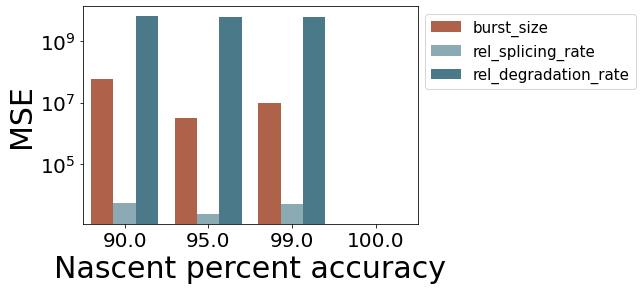

In [22]:
# and PLOT !!! 

# fig,ax = plt.subplots(1,3)
fs = 30
save_path = None
metric = 'MSE'
sns.barplot(data=df_plot, x="Accuracy", y=metric, hue = "Parameter" , palette = [colors[0],colors[-2],colors[-1]])

plt.xlabel('Nascent percent accuracy',fontsize=fs)
plt.ylabel(metric,fontsize=fs)
# plt.suptitle('Comparing models',fontsize=fs)
# # plt.ylim(0.,1)
# plt.xticks(fontsize=20,rotation=10)
# plt.yticks(fontsize=25)
# # plt.ylim(0.25,0.7)
plt.yscale('log')
plt.legend(bbox_to_anchor=[1.0, 1.0],fontsize=15)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')



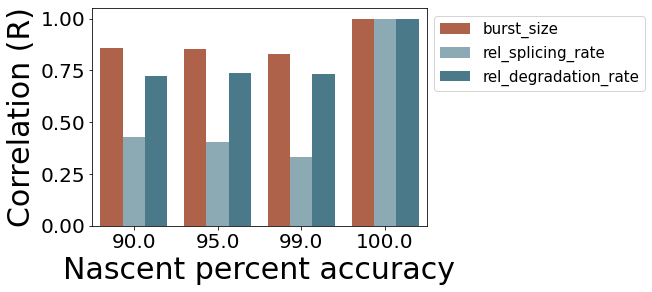

In [23]:
# and PLOT !!! 

# fig,ax = plt.subplots(1,3)
fs = 30
save_path = None
metric = 'Correlation (R)'
sns.barplot(data=df_plot, x="Accuracy", y=metric, hue = "Parameter" , palette = [colors[0],colors[-2],colors[-1]])

plt.xlabel('Nascent percent accuracy',fontsize=fs)
plt.ylabel(metric,fontsize=fs)
# plt.suptitle('Comparing models',fontsize=fs)
# # plt.ylim(0.,1)
# plt.xticks(fontsize=20,rotation=10)
# plt.yticks(fontsize=25)
# # plt.ylim(0.25,0.7)

plt.legend(bbox_to_anchor=[1.0, 1.0],fontsize=15)
# plt.yscale('log')

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')



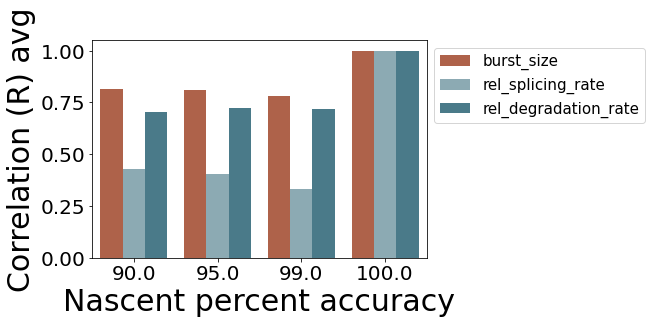

In [24]:
# and PLOT !!! 

# fig,ax = plt.subplots(1,3)
fs = 30
save_path = None
metric = 'Correlation (R) avg'
sns.barplot(data=df_plot, x="Accuracy", y=metric, hue = "Parameter" ,   palette = [colors[0],colors[-2],colors[-1]])

plt.xlabel('Nascent percent accuracy',fontsize=fs)
plt.ylabel(metric,fontsize=fs)
# plt.suptitle('Comparing models',fontsize=fs)
# # plt.ylim(0.,1)
# plt.xticks(fontsize=20,rotation=10)
# plt.yticks(fontsize=25)
# # plt.ylim(0.25,0.7)

plt.legend(bbox_to_anchor=[1.0, 1.0],fontsize=15)
# plt.yscale('log')

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')
